# Preprocessing Vienna data for BikeDNA

* Date of last edit: 2023-03-30
* Data source: [Stadt Wien](https://www.data.gv.at/katalog/dataset/5e6175cd-dc44-4b32-a64a-1ac4239a6e4a#additional-info)

Preprocessing steps:

**In Python**

1. Load data set as geodataframe 
2. Make sure each row contains a linestring geometry (explode if necessary)
3. Explore data set features (which rows and columns are available? Which feature labels appear how often?)
4. Drop not needed rows and columns
5. Check CRS and (if it is a geographic one) project into projected CRS 
6. Add CRS info in the config file

**In QGIS (only visual)**

7. determine whether reference geometries are "true geometries" or "centerline"
8. determine which parts of the infrastructure are bidirectional
9. determine which parts of the infrastructure are protected/unprotected

**In Python**

10. add reference_geometry information (to config file or data frame)
11. add bidirectionality information  (to config file or data frame) 
12. add protection level information (to config file)

**In QGIS (processing!)**

13. Make sure that each linestring endpoint represents an intersection by running the `split with lines` native QGIS processing tool on the dataset of linestrings
14. Export (save) the split dataset 

**In Python**

15. Load the split dataset
16. Add unique ID column to geodataframe 
17. Save final gdf as required by BikeDNA
18. Derive the "study area polygon" from the final dataset and save it as required by BikeDNA

(move the final files to folders after folder structure is created)
***

In [2]:
# Load libraries
import os
import numpy as np
import random
random.seed(42)
import pandas as pd
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString
from shapely import wkt
from collections import Counter
import matplotlib.pyplot as plt

**1. Load data**

In [2]:
gdf = gpd.read_file("./RADWEGEOGD/RADWEGEOGDLine.shp")

**2. Assert: one linestring geometry per row**

In [3]:
gdf = gdf.explode(index_parts = False)
assert all(gdf.geometry.type=="LineString")

**3. Explore data set features**

In [4]:
gdf.head(3)

,MERKMAL,SUBMERKMAL,SE_SDO_ROW,geometry
0,Getrennte Führung,Baulicher Radweg,51857719.0,"LINESTRING (16.32641 48.18416, 16.32629 48.184..."
1,Getrennte Führung,Getrennter Geh- und Radweg,51857720.0,"LINESTRING (16.32746 48.18396, 16.32743 48.183..."
2,Markierte Anlagen,Radfahren gegen die Einbahn,51857721.0,"LINESTRING (16.36256 48.17032, 16.36255 48.170..."


In [5]:
Counter(gdf.MERKMAL)

Counter({'Getrennte Führung': 5108,
         'Markierte Anlagen': 6335,
         'Radroute': 1961,
         'Radfahren im Wald': 81})

In [6]:
Counter(gdf.SUBMERKMAL)

Counter({'Baulicher Radweg': 1645,
         'Getrennter Geh- und Radweg': 570,
         'Radfahren gegen die Einbahn': 3042,
         'Radfahrerüberfahrt': 1887,
         'Verkehrsberuhigter Bereich': 1550,
         'Radroute': 1961,
         'Gemischter Geh- und Radweg': 862,
         'Mehrzweckstreifen': 996,
         'Radfahrstreifen': 292,
         'Radfahren auf Busspur': 118,
         'Mountainbikestrecke': 81,
         'Radfahren in Wohnstraße': 317,
         'Radfahren in Fußgängerzone': 112,
         'Fahrradstraße': 52})

In [7]:
Counter(gdf[gdf["MERKMAL"]=="Getrennte Führung"]["SUBMERKMAL"])

Counter({'Baulicher Radweg': 1645,
         'Getrennter Geh- und Radweg': 570,
         'Verkehrsberuhigter Bereich': 1550,
         'Gemischter Geh- und Radweg': 862,
         'Radfahren in Wohnstraße': 317,
         'Radfahren in Fußgängerzone': 112,
         'Fahrradstraße': 52})

In [8]:
Counter(gdf[gdf["MERKMAL"]=="Markierte Anlagen"]["SUBMERKMAL"])

Counter({'Radfahren gegen die Einbahn': 3042,
         'Radfahrerüberfahrt': 1887,
         'Mehrzweckstreifen': 996,
         'Radfahrstreifen': 292,
         'Radfahren auf Busspur': 118})

In [9]:
Counter(gdf["SE_SDO_ROW"])

Counter({51857719.0: 1,
         51857720.0: 1,
         51857721.0: 1,
         51857722.0: 1,
         51857723.0: 1,
         51857724.0: 1,
         51857725.0: 1,
         51857726.0: 1,
         51857727.0: 1,
         51857728.0: 1,
         51857729.0: 1,
         51857730.0: 1,
         51857731.0: 1,
         51857732.0: 1,
         51857733.0: 1,
         51857734.0: 1,
         51857735.0: 1,
         51857736.0: 1,
         51857737.0: 1,
         51857738.0: 1,
         51857739.0: 1,
         51857740.0: 1,
         51857741.0: 1,
         51857742.0: 1,
         51857743.0: 1,
         51857744.0: 1,
         51857745.0: 1,
         51857746.0: 1,
         51857747.0: 1,
         51857748.0: 1,
         51857749.0: 1,
         51857750.0: 1,
         51857751.0: 1,
         51857752.0: 1,
         51857753.0: 1,
         51857754.0: 1,
         51857755.0: 1,
         51857756.0: 1,
         51857757.0: 1,
         51857758.0: 1,
         51857759.0: 1,
         5185776

**4. Drop not needed rows and columns**

In [10]:
gdf = gdf.drop(columns = "SE_SDO_ROW")

In [11]:
gdf = gdf.drop(gdf[gdf["MERKMAL"]=="Radroute"].index, axis = 0).reset_index(drop=True)

**5. Check CRS and project into projected one**

In [12]:
print(gdf.crs)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


In [13]:
gdf = gdf.to_crs("EPSG:32633")

***

**6. In cofiguration file**

> `study_crs: EPSG:32633`

***

#### In QGIS: 

**7. Check mapping type** 

To correctly fill out `reference_geometries` field of configuration file: check whether in the data set we have true geometries or centerline mapping (to later classify in Python and/or indicate in the configuration file); 

**8. Check bidirectionality**

Check which parts of the infrastructure are bidirectional and which ones are not (to later classify in Python and/or indicate in the configuration file)

**9. Check protection level**

Check which parts of the infrastructure are protected and which ones are not (to later indicate in the configuration file)

***

**10. Add mapping type information to config file**

> reference_geometries: true_geometries

**11. Add and fill `is_bidirectional` column**

In [15]:
def classify_bidirection(mystring, oneways, twoways):
    if mystring in twoways:
        return True
    elif mystring in oneways:
        return False
    else:
        return None
    
myoneways = [
    'Radfahren gegen die Einbahn',
    'Radfahren auf Busspur',
    'Mehrzweckstreifen',
    'Radfahrstreifen',
    'Baulicher Radweg'
]

mytwoways = [
    'Mountainbikestrecke',
    'Radfahrerüberfahrt',
    'Radfahren in Wohnstraße',
    'Fahrradstraße',
    'Radfahren in Fußgängerzone',
    'Gemischter Geh- und Radweg',
    'Getrennter Geh- und Radweg',
    'Verkehrsberuhigter Bereich'
]

gdf["is_bidirectional"] = gdf.apply(
    lambda x: classify_bidirection(
        mystring = x.SUBMERKMAL, 
        oneways = myoneways, 
        twoways = mytwoways), 
    axis = 1)

> In config file: `bidirectional: is_bidirectional`

**12. In configuration file, classify in protected/unprotected by name and value of columns:**

> ```ref_bicycle_infrastructure_type:
>
>   protected:
>
>    - "MERKMAL ==  'Getrennte Führung'"
>
>    - "MERKMAL ==  'Radfahren im Wald'"
>
>   unprotected:
>  
>    - "MERKMAL == 'Markierte Anlagen'"

**13. Save temporary file for QGIS processing**

In [16]:
gdf.to_file("qgis_input.gpkg", index = False)

***

#### In QGIS: 

Run the *split with lines* processing algorithm and save the output file, by navigating to the Python console within QGIS (in a project saved in the same folder as the `qgis_input.gpkg` data) and then running the script `splitwithlines.py`, which takes care of the following 2 points:

13. Make sure that each linestring endpoint represents an intersection by running the `split with lines` native QGIS processing tool on the dataset of linestrings
14. Export (save) the split dataset 

***

**In Python**

15. Load the split dataset
16. Add unique ID column to geodataframe 
17. Save final gdf as required by BikeDNA
17. Derive the "study area polygon" from the final dataset and save it as required by BikeDNA

**15. Load the output data set**

In [3]:
split = gpd.read_file("qgis_output.gpkg")
split = split.explode(index_parts = False)

**16. Add unique ID column**

In [4]:
split["myid"] = split.index

> in config file: `reference_id_col: myid`

**17. Save final gdf as required by BikeDNA**

In [23]:
split.to_file("reference_data.gpkg", index = False)

* have all geometries as LineStrings (not MultiLineStrings)
* have all intersections represented as LineString endpoints (?)


**18. Derive study area polygon from reference data set and save it as required**
/data/study_area_polygon/'my_study_area'/study_area_polygon.gpkg

In [11]:
study_area_polygon = split.unary_union.envelope.buffer(100)
study_area_polygon = gpd.GeoDataFrame(geometry = [study_area_polygon], crs = split.crs)
study_area_polygon.to_file("study_area_polygon.gpkg")

<AxesSubplot: >

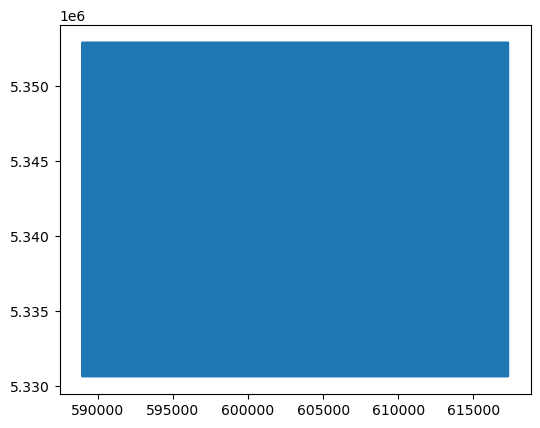

In [13]:
study_area_polygon.plot()

**Municipal boundary of Vienna for 2nd run**

In [3]:
import osmnx as ox

In [4]:
wien = ox.geocoder.geocode_to_gdf("Vienna")
wien = wien.to_crs("EPSG:32633")
#wien[["geometry"]].to_file("study_area_polygon_municipal.gpkg")

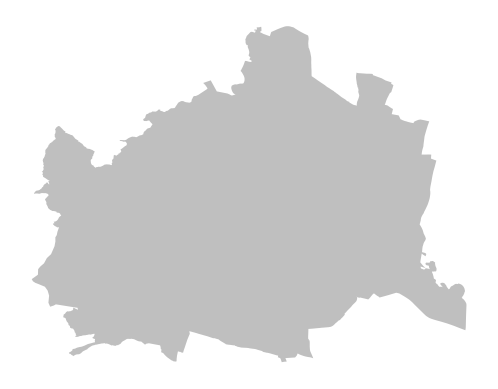

In [10]:
_ , ax = plt.subplots(1,1)
wien.plot(ax=ax, color = "grey", alpha = 0.5)
ax.set_axis_off()
plt.savefig("../presentation/viennapoly.png"
)